# Anesthesia 

In [48]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
import os


from filtered_point_process.PointProcess import PointProcessModel
from filtered_point_process.FPP import FilteredPointProcess

# Load the .mat file
mat_file_path = '.../filtered-point-process/filtered_point_process/Notebooks/Figure_Code_Bloniasz_et_al_2024/Figure_A_Blue.mat'
data = scipy.io.loadmat(mat_file_path)

# Extract data
spectrogram_log = data['Spectrogram (log-transformed)']
frequencies = data['frequencies'].squeeze()
time = data['time'].squeeze()
awake_psd = data['Awake PSD'].squeeze()
anes_psd = data['Anes PSD'].squeeze()
timestamps_labels = data['timestamps_labels']

spectrogram_linear = data['Spectrogram (Original)']
start_time = 45 # 41.5
end_time = start_time + 4
time_range_filter = (time >= start_time) & (time < end_time)
filtered_time_range = time[time_range_filter]
filtered_spectrogram_range = spectrogram_linear[:, time_range_filter]

# Calculate mean power spectrum for the filtered time range
mean_power_spectrum = filtered_spectrogram_range.mean(axis=1)

 
negative_frequencies = -frequencies[1:][::-1]  # Exclude zero frequency and reverse
negative_power_spectrum = mean_power_spectrum[1:][::-1]  # Exclude zero frequency power and reverse

# Concatenate negative and positive frequencies
extended_frequencies = np.concatenate((negative_frequencies, frequencies))
extended_power_spectrum = np.concatenate((negative_power_spectrum, mean_power_spectrum))

# Objective function for optimization
def objective(params):
    # Extract current parameters
    peak_height_1, center_frequency_1, peak_width_1, \
    peak_height_2, center_frequency_2, peak_width_2, \
    lambda_0_AMPA, lambda_0_GABA, transform_param_1, \
    transform_param_2, tau_decay_AMPA, tau_decay_GABA, \
    tau_rise_AMPA, tau_rise_GABA, A_filter = params

       
    new_params = {
        'method': 'gaussian',
        'lambda_0': [0],  # lambda_0 dummy value here (will be updated so this is not necessary in the multivariate refactoring)
        'peak_height': peak_height_1,
        'center_frequency': center_frequency_1,
        'peak_width': peak_width_1,
        'peak_height_2': peak_height_2,
        'center_frequency_2': center_frequency_2,
        'peak_width_2': peak_width_2,
        'fs': 1/0.001, 
        'T': 1,         
        'Nsims': 1,
        'frequency_vector': frequencies     
    }

    # Instantiate the PointProcessModel with current parameters
    model_1 = PointProcessModel(params=new_params, seed=45)

    # Calculate the theoretical spectrum (CIF) with the current parameters
    S_ampa = model_1.cif_PSD
    S_gaba = model_1.cif_PSD 

    theoretical_frequencies = model_1.params['frequencies']

    # Define the filters to be used
    filters = {
        'AMPA': 'AMPA',
        'GABA': 'GABA',
        '1/f': '1/f'
    }

    # Define custom parameters for the filters
    filter_params = {
        'AMPA': {'tau_rise': tau_rise_AMPA / 1000, 'tau_decay': tau_decay_AMPA / 1000},
        'GABA': {'tau_rise': tau_rise_GABA / 1000, 'tau_decay': tau_decay_GABA / 1000},
        '1/f': {'A': A_filter}
    }

    # Instantiate the FilteredPointProcess class with the specified filters, model, and custom parameters
    fpp = FilteredPointProcess(filters=filters, model=model_1, filter_params=filter_params)

    filter_spectra = fpp.get_filters()

    # Extract the filters and densities
    mirrored_positive_filters_ampa = filter_spectra['AMPA']['power_spectrum']
    mirrored_positive_filters_gaba = filter_spectra['GABA']['power_spectrum']
    mirrored_positive_filters_1_f = filter_spectra['1/f']['power_spectrum']
    ampa_density = filter_spectra['AMPA']['kernel_density_not_squared']
    gaba_density = filter_spectra['GABA']['kernel_density_not_squared']

    # Constructing the S_ampa_gaba tensor directly using CIF
    S_ampa_gaba = np.zeros((2, 2, len(theoretical_frequencies)), dtype=complex)

    # Fill the tensor with provided data using the correct spectral equations
    S_ampa_gaba[0, 0, :] = (S_ampa + lambda_0_AMPA) * mirrored_positive_filters_ampa * mirrored_positive_filters_1_f * transform_param_1**2
    S_ampa_gaba[0, 1, :] = S_ampa * ampa_density * np.conj(gaba_density) * mirrored_positive_filters_1_f * (transform_param_1 * np.conj(transform_param_2))
    S_ampa_gaba[1, 0, :] = np.conj(S_ampa) * np.conj(ampa_density) * gaba_density * np.conj(mirrored_positive_filters_1_f) * (transform_param_2 * np.conj(transform_param_1))
    S_ampa_gaba[1, 1, :] = (S_gaba + lambda_0_GABA) * mirrored_positive_filters_gaba * mirrored_positive_filters_1_f * transform_param_2**2


    # Calculate the final spectrum: sum of the components transformed by the squared vector
    theoretical_spectrum = np.sum(S_ampa_gaba, axis=(0, 1))

    # Transform to log space
    log_theoretical_spectrum = theoretical_spectrum  # Prevent log of zero

    # Mean Absolute Error as the objective
    mae = np.mean(np.abs(extended_power_spectrum - log_theoretical_spectrum))
    return mae

# Initial parameters
initial_params = [2.446870e+03, 9.604499e-01, 7.500000e-01, 1.825298e+03, 1.721108e+01, 2.000000e+00, 6.767723e+03, 3.366484e+02, 1.750964e+03, 2.162582e+03, 1.230482e+00, 4.838675e+00, 2.666333e-01, 2.680273e-01, 7.000000e+00]


# Full bounds for all parameters
full_bounds = [
    (2000, 3000),    # peak_height_1 0 
    (0.5, 1),          # center_frequency_1 1
    (0.75, 1),         # peak_width_1 2
    (100, 20000),     # peak_height_2 3
    (16, 18),          # center_frequency_2 4
    (1, 2),         # peak_width_2 5
    (5000, 9000),      # lambda_0_AMPA 6
    (300, 900),       # lambda_0_GABA 7
    (1000, 100000),     # transform_param_1 8
    (200, 100000),      # transform_param_2 9
    (1, 3),         # tau_decay_AMPA 10
    (3, 10),         # tau_decay_GABA 11
    (0.1, 0.4),        # tau_rise_AMPA 12
    (0.1, 0.4),        # tau_rise_GABA 13
    (2, 7)          # A_filter 14
]

# Perform optimization using Differential Evolution
result = differential_evolution(
    objective,
    full_bounds,
    strategy='best1bin',
    maxiter=20,
    popsize=50,
    tol=0.01,
    seed=42
)

# Extract optimized parameters
optimized_params = result.x

print(f"Optimized Parameters: {optimized_params}")
print(f"Minimized Mean Absolute Error: {result.fun}")


Optimized Parameters: [2.67587854e+03 1.00000000e+00 7.50000000e-01 8.46071143e+03
 1.79625935e+01 1.00000000e+00 7.73060965e+03 8.00458531e+02
 1.12719132e+03 1.10676832e+03 1.23287516e+00 8.45838521e+00
 2.59814084e-01 4.00000000e-01 7.00000000e+00]
Minimized Mean Absolute Error: 15.45861532884248


In [49]:
Optimized_Parameters_Anesthesia = [1.748274e+04, 8.345333e-01, 7.500000e-01, 8.090926e+03, 1.761947e+01, 2.471170e+00, 4.672804e+03, 9.707258e+02, 3.058265e+03, 3.199235e+02, 1.430417e+00, 1.003044e+01, 3.903139e-01, 3.953311e-01, 8.649396e+00]
Optimized_Parameters_Anesthesia_2 = [2.291445e+03, 1.000000e+00, 7.500000e-01, 1.230476e+04, 2.700000e+01, 9.557983e+00, 2.184298e+03, 2.000000e+02, 1.462175e+03, 2.024970e+02, 1.967853e+00, 5.000000e+01, 1.000000e-01, 1.000000e-01, 7.000000e+00]
Optimized_Parameters_Anesthesia_3 = [2.574863e+03, 9.615408e-01, 7.500000e-01, 1.576331e+03, 2.821703e+01, 8.867494e+00, 6.645727e+03, 3.000000e+02, 1.741368e+03, 2.083780e+03, 1.000212e+00, 5.115506e+00, 1.189245e-01, 3.994762e-01, 7.000000e+00]
Optimized_Parameters_Anesthesia_4 = [2.446870e+03, 9.604499e-01, 7.500000e-01, 1.825298e+03, 1.721108e+01, 2.000000e+00, 6.767723e+03, 3.366484e+02, 1.750964e+03, 2.162582e+03, 1.230482e+00, 4.838675e+00, 2.666333e-01, 2.680273e-01, 7.000000e+00]

## 45 minutes
Optimized_Parameters_Anesthesia_5 = [2.446870e+03, 9.604499e-01, 7.500000e-01, 1.425298e+03, 
                                     1.721108e+01, 2.000000e+00, 6.767723e+03, 3.366484e+02, 
                                     1.750964e+03, 2.162582e+03, 1.230482e+00, 4.838675e+00, 
                                     2.666333e-01, 2.680273e-01, 7.000000e+00]
# Plot the optimized spectra


In [50]:
 
#optimized_params = result.x


#optimized_params_str = ', '.join([f'{param:.6e}' for param in optimized_params])

# Print the formatted string
#print(f"Optimized Parameters: [{optimized_params_str}]")


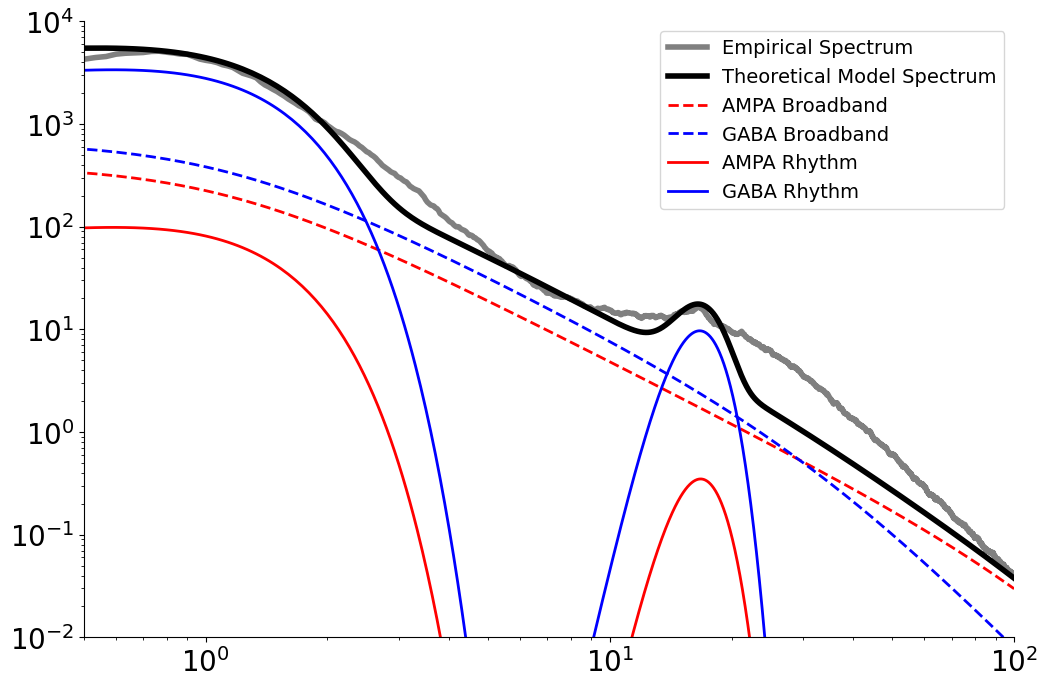

In [51]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

optimized_params = Optimized_Parameters_Anesthesia_5 # Optimized_Parameters_Anesthesia_4

# Extract optimized parameters
peak_height_1, center_frequency_1, peak_width_1, \
peak_height_2, center_frequency_2, peak_width_2, \
lambda_0_AMPA, lambda_0_GABA, transform_param_1, \
transform_param_2, tau_decay_AMPA, tau_decay_GABA, \
tau_rise_AMPA, tau_rise_GABA, A_filter = optimized_params


# Calculate mean power spectrum for the filtered time range
mean_power_spectrum = filtered_spectrogram_range.mean(axis=1)

 
negative_frequencies = -frequencies[1:][::-1]  # Exclude zero frequency and reverse
negative_power_spectrum = mean_power_spectrum[1:][::-1]  # Exclude zero frequency power and reverse

# Concatenate negative and positive frequencies
extended_frequencies = np.concatenate((negative_frequencies, frequencies))
extended_power_spectrum = np.concatenate((negative_power_spectrum, mean_power_spectrum))

  
new_params = {
    'method': 'gaussian',
    'lambda_0': [0],   # lambda_0 dummy value here (will be updated so this is not necessary in the multivariate refactoring)ed
    'peak_height': peak_height_1,
    'center_frequency': center_frequency_1,
    'peak_width': peak_width_1,
    'peak_height_2': peak_height_2,
    'center_frequency_2': center_frequency_2,
    'peak_width_2': peak_width_2,
    'fs': 1/0.001,   
    'T': 1,           
    'Nsims': 1,
    'frequency_vector': frequencies     
}

# Instantiate the PointProcessModel with current parameters
model_1 = PointProcessModel(params=new_params, seed=45)

# Calculate the theoretical spectrum (CIF) with the current parameters
S_ampa = model_1.cif_PSD
S_gaba = model_1.cif_PSD 

theoretical_frequencies = model_1.params['frequencies']

# Define the filters to be used
filters = {
    'AMPA': 'AMPA',
    'GABA': 'GABA',
    '1/f': '1/f'
}

# Define custom parameters for the filters
filter_params = {
    'AMPA': {'tau_rise': tau_rise_AMPA / 1000, 'tau_decay': tau_decay_AMPA / 1000},
    'GABA': {'tau_rise': tau_rise_GABA / 1000, 'tau_decay': tau_decay_GABA / 1000},
    '1/f': {'A': A_filter}
}

# Instantiate the FilteredPointProcess class with the specified filters, model, and custom parameters
fpp = FilteredPointProcess(filters=filters, model=model_1, filter_params=filter_params)

filter_spectra = fpp.get_filters()

mirrored_positive_filters_ampa = filter_spectra['AMPA']['power_spectrum']
mirrored_positive_filters_gaba = filter_spectra['GABA']['power_spectrum']
mirrored_positive_filters_1_f = filter_spectra['1/f']['power_spectrum']
ampa_density = filter_spectra['AMPA']['kernel_density_not_squared']
gaba_density = filter_spectra['GABA']['kernel_density_not_squared']

# Constructing the S_ampa_gaba tensor directly using CIF
S_ampa_gaba = np.zeros((2, 2, len(theoretical_frequencies)), dtype=complex)

# Fill the tensor with provided data using the correct spectral equations
S_ampa_gaba[0, 0, :] = (S_ampa + lambda_0_AMPA) * mirrored_positive_filters_ampa * mirrored_positive_filters_1_f * transform_param_1**2
S_ampa_gaba[0, 1, :] = S_ampa * ampa_density * np.conj(gaba_density) * mirrored_positive_filters_1_f * (transform_param_1 * np.conj(transform_param_2))
S_ampa_gaba[1, 0, :] = np.conj(S_ampa) * np.conj(ampa_density) * gaba_density * np.conj(mirrored_positive_filters_1_f) * (transform_param_2 * np.conj(transform_param_1))
S_ampa_gaba[1, 1, :] = (S_gaba + lambda_0_GABA) * mirrored_positive_filters_gaba * mirrored_positive_filters_1_f * transform_param_2**2

# Define the transformation vector
transformation_vector = np.array([transform_param_1, transform_param_2])
transformation_vector_squared = transformation_vector ** 2

# Calculate the final spectrum: sum of the components transformed by the squared vector
theoretical_spectrum = np.sum(S_ampa_gaba, axis=(0, 1))

# Individual subcomponents after transformation
CIF_AMPA = (
    S_ampa
    * mirrored_positive_filters_ampa
    * mirrored_positive_filters_1_f
    * transformation_vector_squared[0]
)
CIF_GABA = (
    S_gaba
    * mirrored_positive_filters_gaba
    * mirrored_positive_filters_1_f
    * transformation_vector_squared[1]
)

GABA_broadband = (
    np.full(len(S_gaba), lambda_0_GABA)
    * mirrored_positive_filters_gaba
    * mirrored_positive_filters_1_f
    * transformation_vector_squared[1]
)
AMPA_broadband = (
    np.full(len(S_ampa), lambda_0_AMPA)
    * mirrored_positive_filters_ampa
    * mirrored_positive_filters_1_f
    * transformation_vector_squared[0]
)


# Plotting the results
fig, ax3 = plt.subplots(figsize=(12, 8))

extended_frequencies_spectrum_1 = extended_frequencies
extended_power_spectrum_spectrum_1 = extended_power_spectrum
theoretical_spectrum_spectrum_1 = theoretical_spectrum
AMPA_broadband_spectrum_1 = AMPA_broadband
GABA_broadband_spectrum_1 = GABA_broadband
CIF_AMPA_spectrum_1 = CIF_AMPA
CIF_GABA_spectrum_1 = CIF_GABA

# Plot the empirical and theoretical spectra
ax3.loglog(extended_frequencies_spectrum_1, extended_power_spectrum_spectrum_1, color='grey', label='Empirical Spectrum', linewidth=4)
ax3.loglog(extended_frequencies_spectrum_1, theoretical_spectrum_spectrum_1, color='black', label='Theoretical Model Spectrum', linewidth=4)

# Plot the AMPA and GABA subcomponents
ax3.loglog(extended_frequencies_spectrum_1, AMPA_broadband_spectrum_1, color='red', label='AMPA Broadband', linestyle='--', linewidth=2)
ax3.loglog(extended_frequencies_spectrum_1, GABA_broadband_spectrum_1, color='blue', label='GABA Broadband', linestyle='--', linewidth=2)
ax3.loglog(extended_frequencies_spectrum_1, CIF_AMPA_spectrum_1, color='red', label='AMPA Rhythm', linestyle='-', linewidth=2)
ax3.loglog(extended_frequencies_spectrum_1, CIF_GABA_spectrum_1, color='blue', label='GABA Rhythm', linestyle='-', linewidth=2)

# Customize the plot
ax3.set_xlim(0.5, 100)
ax3.set_ylim(1e-2, 1e4)
ax3.tick_params(axis='both', which='major', labelsize=20)

# Remove the top and right lines
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

# Add the legend
ax3.legend(fontsize=14, loc='upper right')

plt.show()


In [52]:
extended_frequencies_spectrum_1.shape, extended_power_spectrum_spectrum_1.shape

((6001,), (6001,))

## Awake 

In [53]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
import os

# Calculate mean power spectrum for the filtered time range
mean_power_spectrum = awake_psd  # Use Awake PSD directly

 
negative_frequencies = -frequencies[1:][::-1]  # Exclude zero frequency and reverse
negative_power_spectrum = mean_power_spectrum[1:][::-1]  # Exclude zero frequency power and reverse

# Concatenate negative and positive frequencies
extended_frequencies = np.concatenate((negative_frequencies, frequencies))
extended_power_spectrum = np.concatenate((negative_power_spectrum, mean_power_spectrum))

# Objective function for optimization
def objective(params):
    # Extract current parameters
    lambda_0_AMPA, lambda_0_GABA, transform_param_1, \
    transform_param_2, tau_decay_AMPA, tau_decay_GABA, \
    tau_rise_AMPA, tau_rise_GABA, A_filter = params

       
    new_params = {
        'method': 'Homogeneous_Poisson',  
        'lambda_0': [0],   # lambda_0 dummy value here (will be updated so this is not necessary in the multivariate refactoring)ed
        'fs': 1/0.001,   
        'T': 1,           
        'Nsims': 1,
        'frequency_vector': frequencies     
    }

    # Instantiate the PointProcessModel with current parameters
    model_1 = PointProcessModel(params=new_params, seed=45)

    # Calculate the theoretical spectrum (CIF) with the current parameters
    S_ampa = model_1.cif_PSD
    S_gaba = model_1.cif_PSD 

    theoretical_frequencies = model_1.params['frequencies']

    # Define the filters to be used
    filters = {
        'AMPA': 'AMPA',
        'GABA': 'GABA',
        '1/f': '1/f'
    }

    # Define custom parameters for the filters
    filter_params = {
        'AMPA': {'tau_rise': tau_rise_AMPA / 1000, 'tau_decay': tau_decay_AMPA / 1000},
        'GABA': {'tau_rise': tau_rise_GABA / 1000, 'tau_decay': tau_decay_GABA / 1000},
        '1/f': {'A': A_filter}
    }

    # Instantiate the FilteredPointProcess class with the specified filters, model, and custom parameters
    fpp = FilteredPointProcess(filters=filters, model=model_1, filter_params=filter_params)

    filter_spectra = fpp.get_filters()

    # Ensure all spectra are correctly aligned
    mirrored_positive_filters_ampa = filter_spectra['AMPA']['power_spectrum']
    mirrored_positive_filters_gaba = filter_spectra['GABA']['power_spectrum']
    mirrored_positive_filters_1_f = filter_spectra['1/f']['power_spectrum']

    # Constructing the S_ampa_gaba tensor directly using CIF
    S_ampa_gaba = np.zeros((2, 2, len(theoretical_frequencies)), dtype=complex)

    # Fill the tensor with provided data using the correct spectral equations
    S_ampa_gaba[0, 0, :] = (S_ampa + lambda_0_AMPA) * mirrored_positive_filters_ampa * mirrored_positive_filters_1_f
    S_ampa_gaba[0, 1, :] = 0  # no cross-terms
    S_ampa_gaba[1, 0, :] = 0  # no cross-terms
    S_ampa_gaba[1, 1, :] = (S_gaba + lambda_0_GABA) * mirrored_positive_filters_gaba * mirrored_positive_filters_1_f

    # Define the transformation vector
    transformation_vector = np.array([transform_param_1, transform_param_2])
    transformation_vector_squared = transformation_vector ** 2

    # Calculate the final spectrum: sum of the components transformed by the squared vector
    theoretical_spectrum = np.sum(S_ampa_gaba, axis=(0, 1))

    # Transform to log space
    log_theoretical_spectrum = theoretical_spectrum  # Prevent log of zero

    # Mean Absolute Error as the objective
    mae = np.mean(np.abs(extended_power_spectrum - log_theoretical_spectrum))
    return mae

# Initial parameters
initial_params = [2.184298e+03, 2.000000e+02, 1.462175e+03, 2.024970e+02, 1.967853e+00, 5.000000e+01, 1.000000e-01, 1.000000e-01, 7.000000e+00]

# Full bounds for all parameters
full_bounds = [
    (100, 10000),      # lambda_0_AMPA 6
    (100, 10000),       # lambda_0_GABA 7
    (100, 1000),     # transform_param_1 8
    (100, 1000),      # transform_param_2 9
    (1, 4),         # tau_decay_AMPA 10
    (6, 50),         # tau_decay_GABA 11
    (0.1, 0.4),        # tau_rise_AMPA 12
    (0.1, 0.4),        # tau_rise_GABA 13
    (1, 100)          # A_filter 14
]
'''
# Perform optimization using Differential Evolution
result = differential_evolution(
    objective,
    full_bounds,
    strategy='best1bin',
    maxiter=20,
    popsize=50,
    tol=0.01,
    seed=42
)

# Extract optimized parameters
optimized_params = result.x

print(f"Optimized Parameters: {optimized_params}")
print(f"Minimized Mean Absolute Error: {result.fun}")
'''

'\n# Perform optimization using Differential Evolution\nresult = differential_evolution(\n    objective,\n    full_bounds,\n    strategy=\'best1bin\',\n    maxiter=20,\n    popsize=50,\n    tol=0.01,\n    seed=42\n)\n\n# Extract optimized parameters\noptimized_params = result.x\n\nprint(f"Optimized Parameters: {optimized_params}")\nprint(f"Minimized Mean Absolute Error: {result.fun}")\n'

In [ ]:
'''
 
optimized_params = result.x

optimized_params_str = ', '.join([f'{param:.6e}' for param in optimized_params])

# Print the formatted string
print(f"Optimized Parameters: [{optimized_params_str}]")
'''

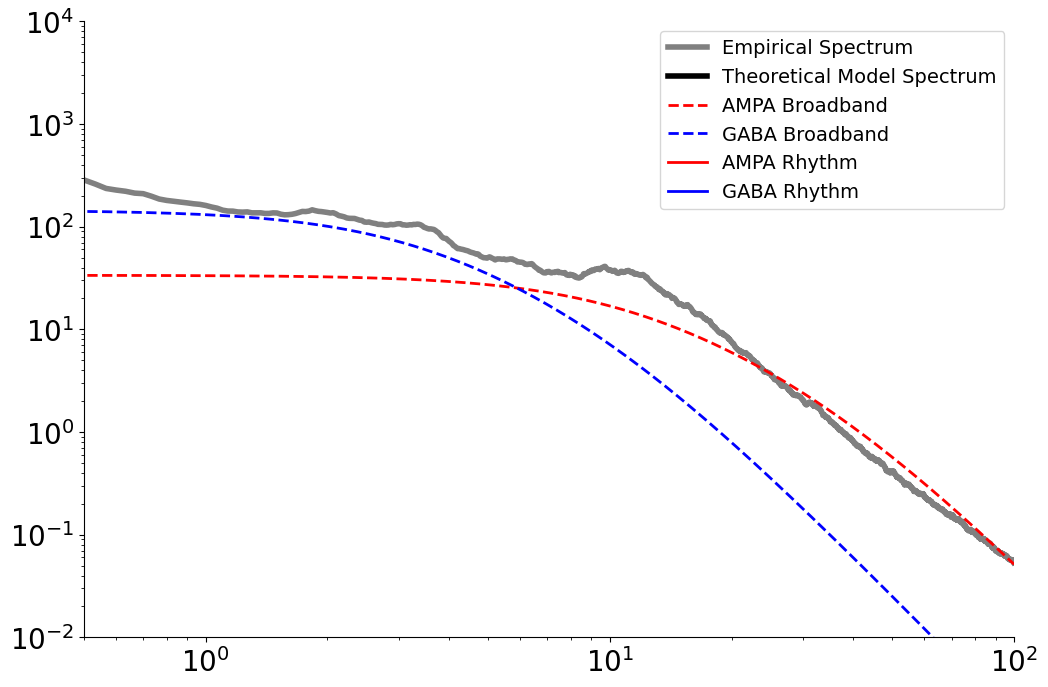

In [55]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

Awake = [9.905219e+03, 4.559880e+03, 1.000000e+03, 2.399343e+02, 4.000000e+00, 5.000000e+01, 1.000000e-01, 4.000000e-01, 6.691068e+01]

optimized_params = Awake

# Extract optimized parameters
lambda_0_AMPA, lambda_0_GABA, transform_param_1, \
transform_param_2, tau_decay_AMPA, tau_decay_GABA, \
tau_rise_AMPA, tau_rise_GABA, A_filter = optimized_params

# Use the Awake PSD directly for the empirical spectrum
mean_power_spectrum = awake_psd

 
negative_frequencies = -frequencies[1:][::-1]  # Exclude zero frequency and reverse
negative_power_spectrum = mean_power_spectrum[1:][::-1]  # Exclude zero frequency power and reverse

# Concatenate negative and positive frequencies
extended_frequencies = np.concatenate((negative_frequencies, frequencies))
extended_power_spectrum = np.concatenate((negative_power_spectrum, mean_power_spectrum))

  
new_params = {
    'method': 'Homogeneous_Poisson',
    'lambda_0': [0],   # lambda_0 dummy value here (will be updated so this is not necessary in the multivariate refactoring)ed
    'fs': 1/0.001,   
    'T': 1,           
    'Nsims': 1,
    'frequency_vector': frequencies     
}

# Instantiate the PointProcessModel with current parameters
model_1 = PointProcessModel(params=new_params, seed=45)

# Calculate the theoretical spectrum (CIF) with the current parameters
S_ampa = model_1.cif_PSD
S_gaba = model_1.cif_PSD 

theoretical_frequencies = model_1.params['frequencies']

# Define the filters to be used
filters = {
    'AMPA': 'AMPA',
    'GABA': 'GABA',
    '1/f': '1/f'
}

# Define custom parameters for the filters
filter_params = {
    'AMPA': {'tau_rise': tau_rise_AMPA / 1000, 'tau_decay': tau_decay_AMPA / 1000},
    'GABA': {'tau_rise': tau_rise_GABA / 1000, 'tau_decay': tau_decay_GABA / 1000},
    '1/f': {'A': A_filter}
}

# Instantiate the FilteredPointProcess class with the specified filters, model, and custom parameters
fpp = FilteredPointProcess(filters=filters, model=model_1, filter_params=filter_params)

filter_spectra = fpp.get_filters()

# Ensure all spectra are correctly aligned
mirrored_positive_filters_ampa = filter_spectra['AMPA']['power_spectrum']
mirrored_positive_filters_gaba = filter_spectra['GABA']['power_spectrum']
mirrored_positive_filters_1_f = filter_spectra['1/f']['power_spectrum']

# Constructing the S_ampa_gaba tensor directly using CIF
S_ampa_gaba = np.zeros((2, 2, len(theoretical_frequencies)), dtype=complex)

# Fill the tensor with provided data using the correct spectral equations
S_ampa_gaba[0, 0, :] = (lambda_0_AMPA) * mirrored_positive_filters_ampa * mirrored_positive_filters_1_f
S_ampa_gaba[0, 1, :] = 0  # no cross-terms
S_ampa_gaba[1, 0, :] = 0  # no cross-terms
S_ampa_gaba[1, 1, :] = (lambda_0_GABA) * mirrored_positive_filters_gaba * mirrored_positive_filters_1_f

# Define the transformation vector
transformation_vector = np.array([transform_param_1, transform_param_2])
transformation_vector_squared = transformation_vector ** 2

# Calculate the final spectrum: sum of the components transformed by the squared vector
theoretical_spectrum = np.sum(S_ampa_gaba, axis=(0, 1))

# Individual subcomponents after transformation
CIF_AMPA = (
    S_ampa
    * mirrored_positive_filters_ampa
    * mirrored_positive_filters_1_f
    * transformation_vector_squared[0]
)
CIF_GABA = (
    S_gaba
    * mirrored_positive_filters_gaba
    * mirrored_positive_filters_1_f
    * transformation_vector_squared[1]
)

GABA_broadband = (
    np.full(len(S_gaba), lambda_0_GABA)
    * mirrored_positive_filters_gaba
    * mirrored_positive_filters_1_f
    * transformation_vector_squared[1]
)
AMPA_broadband = (
    np.full(len(S_ampa), lambda_0_AMPA)
    * mirrored_positive_filters_ampa
    * mirrored_positive_filters_1_f
    * transformation_vector_squared[0]
)


# Plotting the results
fig, ax3 = plt.subplots(figsize=(12, 8))

# Plot the empirical and theoretical spectra
ax3.loglog(extended_frequencies, extended_power_spectrum, color='grey', label='Empirical Spectrum', linewidth=4)
ax3.loglog(extended_frequencies, theoretical_spectrum, color='black', label='Theoretical Model Spectrum', linewidth=4)

# Plot the AMPA and GABA subcomponents
ax3.loglog(extended_frequencies, AMPA_broadband, color='red', label='AMPA Broadband', linestyle='--', linewidth=2)
ax3.loglog(extended_frequencies, GABA_broadband, color='blue', label='GABA Broadband', linestyle='--', linewidth=2)
ax3.loglog(extended_frequencies, CIF_AMPA, color='red', label='AMPA Rhythm', linestyle='-', linewidth=2)
ax3.loglog(extended_frequencies, CIF_GABA, color='blue', label='GABA Rhythm', linestyle='-', linewidth=2)

# Customize the plot
ax3.set_xlim(0.5, 100)
ax3.set_ylim(1e-2, 1e4)
ax3.tick_params(axis='both', which='major', labelsize=20)

# Remove the top and right lines
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

# Add the legend
ax3.legend(fontsize=14, loc='upper right')

plt.show()


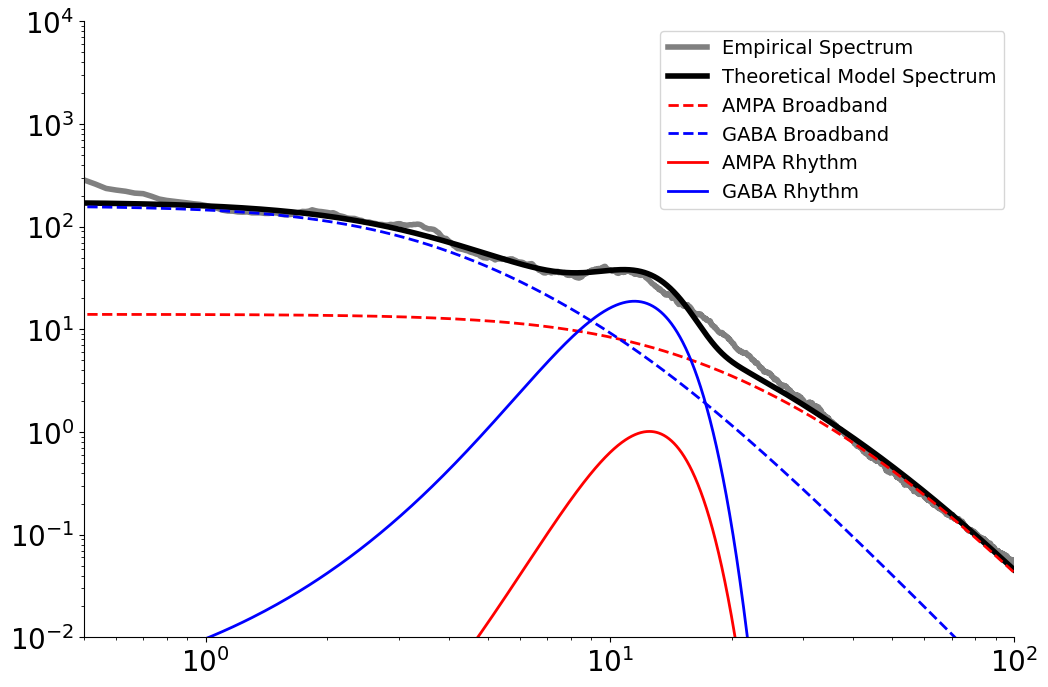

In [56]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
import os


# Use Awake PSD directly for the empirical power spectrum
mean_power_spectrum = awake_psd

 
negative_frequencies = -frequencies[1:][::-1]  # Exclude zero frequency and reverse
negative_power_spectrum = mean_power_spectrum[1:][::-1]  # Exclude zero frequency power and reverse

# Concatenate negative and positive frequencies
extended_frequencies = np.concatenate((negative_frequencies, frequencies))
extended_power_spectrum = np.concatenate((negative_power_spectrum, mean_power_spectrum))

# Objective function for optimization
def objective(params):
    # Extract current parameters
    peak_height, center_frequency, peak_width, \
    lambda_0_AMPA, lambda_0_GABA, transform_param_1, \
    transform_param_2, tau_decay_AMPA, tau_decay_GABA, \
    tau_rise_AMPA, tau_rise_GABA, A_filter = params

       
    new_params = {
        'method': 'gaussian',  # Use Gaussian method
        'lambda_0': [0],   # lambda_0 dummy value here (will be updated so this is not necessary in the multivariate refactoring)ed
        'peak_height': peak_height,
        'center_frequency': center_frequency,
        'peak_width': peak_width,
        'fs': 1/0.001,  
        'T': 1,         
        'Nsims': 1,
        'frequency_vector': frequencies 
    }

    # Instantiate the PointProcessModel with current parameters
    model_1 = PointProcessModel(params=new_params, seed=45)

    # Calculate the theoretical spectrum (CIF) with the current parameters
    S_ampa = model_1.cif_PSD
    S_gaba = model_1.cif_PSD 

    theoretical_frequencies = model_1.params['frequencies']

    # Define the filters to be used
    filters = {
        'AMPA': 'AMPA',
        'GABA': 'GABA',
        '1/f': '1/f'
    }

    # Define custom parameters for the filters
    filter_params = {
        'AMPA': {'tau_rise': tau_rise_AMPA / 1000, 'tau_decay': tau_decay_AMPA / 1000},
        'GABA': {'tau_rise': tau_rise_GABA / 1000, 'tau_decay': tau_decay_GABA / 1000},
        '1/f': {'A': A_filter}
    }

    # Instantiate the FilteredPointProcess class with the specified filters, model, and custom parameters
    fpp = FilteredPointProcess(filters=filters, model=model_1, filter_params=filter_params)

    filter_spectra = fpp.get_filters()

    mirrored_positive_filters_ampa = filter_spectra['AMPA']['power_spectrum']
    mirrored_positive_filters_gaba = filter_spectra['GABA']['power_spectrum']
    mirrored_positive_filters_1_f = filter_spectra['1/f']['power_spectrum']
    ampa_density = filter_spectra['AMPA']['kernel_density_not_squared']
    gaba_density = filter_spectra['GABA']['kernel_density_not_squared']

    # Constructing the S_ampa_gaba tensor directly using CIF
    S_ampa_gaba = np.zeros((2, 2, len(theoretical_frequencies)), dtype=complex)

    # Fill the tensor with provided data using the correct spectral equations
    S_ampa_gaba[0, 0, :] = (S_ampa + lambda_0_AMPA) * mirrored_positive_filters_ampa * mirrored_positive_filters_1_f * transform_param_1**2
    S_ampa_gaba[0, 1, :] = S_ampa * ampa_density * np.conj(gaba_density) * mirrored_positive_filters_1_f * (transform_param_1 * np.conj(transform_param_2))
    S_ampa_gaba[1, 0, :] = np.conj(S_ampa) * np.conj(ampa_density) * gaba_density * np.conj(mirrored_positive_filters_1_f) * (transform_param_2 * np.conj(transform_param_1))
    S_ampa_gaba[1, 1, :] = (S_gaba + lambda_0_GABA) * mirrored_positive_filters_gaba * mirrored_positive_filters_1_f * transform_param_2**2

    # Define the transformation vector
    transformation_vector = np.array([transform_param_1, transform_param_2])
    transformation_vector_squared = transformation_vector ** 2

    # Apply the correct transformation in the frequency domain using einsum
    S_transformed = np.einsum('ijk,j->ijk', S_ampa_gaba, transformation_vector_squared)

    # Calculate the final spectrum: sum of the components transformed by the squared vector
    theoretical_spectrum = np.sum(S_transformed, axis=(0, 1))

    # Mean Absolute Error as the objective
    mae = np.mean(np.abs(extended_power_spectrum - theoretical_spectrum))
    return mae

# Initial parameters
initial_params = [1.00000000e+03, 1.23449958e+01, 2.00000000e+00, 9.41131663e+03,
 2.42310750e+02, 9.99999187e+02, 1.00000000e+03, 3.87172016e+00,
 5.00000000e+01, 3.22185915e-01, 1.00000000e-01, 6.34714047e+01]

# Full bounds for all parameters
full_bounds = [
    (1, 1500),     # peak_height
    (12, 14),        # center_frequency
    (1, 3),        # peak_width
    (100, 10000),     # lambda_0_AMPA
    (100, 10000),     # lambda_0_GABA
    (100, 1000),     # transform_param_1
    (100, 1000),     # transform_param_2
    (1, 4),          # tau_decay_AMPA
    (6, 50),          # tau_decay_GABA
    (0.1, 0.4),      # tau_rise_AMPA
    (0.1, 0.4),      # tau_rise_GABA
    (1, 100)         # A_filter
]
'''
# Perform optimization using Differential Evolution
result = differential_evolution(
    objective,
    full_bounds,
    strategy='best1bin',
    maxiter=20,
    popsize=50,
    tol=0.01,
    seed=42
)

# Extract optimized parameters
optimized_params = result.x

print(f"Optimized Parameters: {optimized_params}")
print(f"Minimized Mean Absolute Error: {result.fun}")
'''
# Plotting Function

Awake_rhythm = [1.50000000e+03, 1.30690611e+01, 2.59384288e+00, 9.77782530e+03,
 4.20672889e+02, 9.77551196e+02, 1.00000000e+03, 3.30000e+00,
 5.00000000e+01, 1.63508138e-01, 1.00000000e-01, 8.09611576e+01]

# Recalculate the theoretical spectrum with optimized parameters
peak_height, center_frequency, peak_width, \
lambda_0_AMPA, lambda_0_GABA, transform_param_1, \
transform_param_2, tau_decay_AMPA, tau_decay_GABA, \
tau_rise_AMPA, tau_rise_GABA, A_filter = Awake_rhythm

new_params = {
    'method': 'gaussian',  # Use Gaussian method
    'lambda_0': [0],   # lambda_0 dummy value here (will be updated so this is not necessary in the multivariate refactoring)ed
    'peak_height': peak_height,
    'center_frequency': center_frequency,
    'peak_width': peak_width,
    'fs': 1/0.001,   
    'T': 1,           
    'Nsims': 1,
    'frequency_vector': frequencies     
}

# Instantiate the PointProcessModel with optimized parameters
model_1 = PointProcessModel(params=new_params, seed=45)

# Calculate the theoretical spectrum (CIF) with the optimized parameters
S_ampa = model_1.cif_PSD
S_gaba = model_1.cif_PSD 

# Define the filters
filters = {
    'AMPA': 'AMPA',
    'GABA': 'GABA',
    '1/f': '1/f'
}

# Define custom parameters for the filters
filter_params = {
    'AMPA': {'tau_rise': tau_rise_AMPA / 1000, 'tau_decay': tau_decay_AMPA / 1000},
    'GABA': {'tau_rise': tau_rise_GABA / 1000, 'tau_decay': tau_decay_GABA / 1000},
    '1/f': {'A': A_filter}
}

# Instantiate the FilteredPointProcess class
fpp = FilteredPointProcess(filters=filters, model=model_1, filter_params=filter_params)

filter_spectra = fpp.get_filters()

# Ensure all spectra are correctly aligned
mirrored_positive_filters_ampa = filter_spectra['AMPA']['power_spectrum']
mirrored_positive_filters_gaba = filter_spectra['GABA']['power_spectrum']
mirrored_positive_filters_1_f = filter_spectra['1/f']['power_spectrum']
ampa_density = filter_spectra['AMPA']['kernel_density_not_squared']
gaba_density = filter_spectra['GABA']['kernel_density_not_squared']

# Constructing the S_ampa_gaba tensor directly using CIF
S_ampa_gaba = np.zeros((2, 2, len(theoretical_frequencies)), dtype=complex)

# Fill the tensor with provided data using the correct spectral equations
S_ampa_gaba[0, 0, :] = (S_ampa + lambda_0_AMPA) * mirrored_positive_filters_ampa * mirrored_positive_filters_1_f * transform_param_1**2
S_ampa_gaba[0, 1, :] = S_ampa * ampa_density * np.conj(gaba_density) * mirrored_positive_filters_1_f * (transform_param_1 * np.conj(transform_param_2))
S_ampa_gaba[1, 0, :] = np.conj(S_ampa) * np.conj(ampa_density) * gaba_density * np.conj(mirrored_positive_filters_1_f) * (transform_param_2 * np.conj(transform_param_1))
S_ampa_gaba[1, 1, :] = (S_gaba + lambda_0_GABA) * mirrored_positive_filters_gaba * mirrored_positive_filters_1_f * transform_param_2**2

# Define the transformation vector
transformation_vector = np.array([transform_param_1, transform_param_2])
transformation_vector_squared = transformation_vector ** 2

# Calculate the final spectrum: sum of the components transformed by the squared vector
theoretical_spectrum = np.sum(S_ampa_gaba, axis=(0, 1))

# Individual subcomponents after transformation
CIF_AMPA = (
    S_ampa
    * mirrored_positive_filters_ampa
    * mirrored_positive_filters_1_f
    * transformation_vector_squared[0]
)
CIF_GABA = (
    S_gaba
    * mirrored_positive_filters_gaba
    * mirrored_positive_filters_1_f
    * transformation_vector_squared[1]
)

GABA_broadband = (
    np.full(len(S_gaba), lambda_0_GABA)
    * mirrored_positive_filters_gaba
    * mirrored_positive_filters_1_f
    * transformation_vector_squared[1]
)
AMPA_broadband = (
    np.full(len(S_ampa), lambda_0_AMPA)
    * mirrored_positive_filters_ampa
    * mirrored_positive_filters_1_f
    * transformation_vector_squared[0]
)

fig, ax = plt.subplots(figsize=(12, 8))


extended_frequencies_spectrum_3 = extended_frequencies
extended_power_spectrum_spectrum_3 = extended_power_spectrum
theoretical_spectrum_spectrum_3 = theoretical_spectrum
AMPA_broadband_spectrum_3 = AMPA_broadband
GABA_broadband_spectrum_3 = GABA_broadband
CIF_AMPA_spectrum_3 = CIF_AMPA
CIF_GABA_spectrum_3 = CIF_GABA

# Plot the empirical and theoretical spectra
ax.loglog(extended_frequencies_spectrum_3, extended_power_spectrum_spectrum_3, color='grey', label='Empirical Spectrum', linewidth=4)
ax.loglog(extended_frequencies_spectrum_3, theoretical_spectrum_spectrum_3, color='black', label='Theoretical Model Spectrum', linewidth=4)

# Plot the AMPA and GABA subcomponents
ax.loglog(extended_frequencies_spectrum_3, AMPA_broadband_spectrum_3, color='red', label='AMPA Broadband', linestyle='--', linewidth=2)
ax.loglog(extended_frequencies_spectrum_3, GABA_broadband_spectrum_3, color='blue', label='GABA Broadband', linestyle='--', linewidth=2)
ax.loglog(extended_frequencies_spectrum_3, CIF_AMPA_spectrum_3, color='red', label='AMPA Rhythm', linestyle='-', linewidth=2)
ax.loglog(extended_frequencies_spectrum_3, CIF_GABA_spectrum_3, color='blue', label='GABA Rhythm', linestyle='-', linewidth=2)

# Customize the plot
ax.set_xlim(0.5, 100)
ax.set_ylim(1e-2, 1e4)
ax.tick_params(axis='both', which='major', labelsize=20)

# Remove the top and right lines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add the legend
ax.legend(fontsize=14, loc='upper right')

plt.show()


## Middle panel

In [57]:
spectrogram_linear = data['Spectrogram (Original)']
start_time = 35
end_time = start_time + 4
time_range_filter = (time >= start_time) & (time < end_time)
filtered_time_range = time[time_range_filter]
filtered_spectrogram_range = spectrogram_linear[:, time_range_filter]

# Calculate mean power spectrum for the filtered time range
mean_power_spectrum = filtered_spectrogram_range.mean(axis=1)


 
negative_frequencies = -frequencies[1:][::-1]  # Exclude zero frequency and reverse
negative_power_spectrum = mean_power_spectrum[1:][::-1]  # Exclude zero frequency power and reverse

# Concatenate negative and positive frequencies
extended_frequencies = np.concatenate((negative_frequencies, frequencies))
extended_power_spectrum = np.concatenate((negative_power_spectrum, mean_power_spectrum))

# Objective function for optimization
def objective(params):
    # Extract current parameters
    lambda_0_AMPA, lambda_0_GABA, transform_param_1, \
    transform_param_2, tau_decay_AMPA, tau_decay_GABA, \
    tau_rise_AMPA, tau_rise_GABA, A_filter = params

       
    new_params = {
        'method': 'Homogeneous_Poisson',  
        'lambda_0': [0],   # lambda_0 dummy value here (will be updated so this is not necessary in the multivariate refactoring)ed
        'fs': 1/0.001,  
        'T': 1,         
        'Nsims': 1,
        'frequency_vector': frequencies  
    }

    # Instantiate the PointProcessModel with current parameters
    model_1 = PointProcessModel(params=new_params, seed=45)

    # Calculate the theoretical spectrum (CIF) with the current parameters
    S_ampa = model_1.cif_PSD
    S_gaba = model_1.cif_PSD 

    theoretical_frequencies = model_1.params['frequencies']

    # Define the filters to be used
    filters = {
        'AMPA': 'AMPA',
        'GABA': 'GABA',
        '1/f': '1/f'
    }

    filter_params = {
        'AMPA': {'tau_rise': tau_rise_AMPA / 1000, 'tau_decay': tau_decay_AMPA / 1000},
        'GABA': {'tau_rise': tau_rise_GABA / 1000, 'tau_decay': tau_decay_GABA / 1000},
        '1/f': {'A': A_filter}
    }

    # Instantiate the FilteredPointProcess class with the specified filters, model, and custom parameters
    fpp = FilteredPointProcess(filters=filters, model=model_1, filter_params=filter_params)

    filter_spectra = fpp.get_filters()

    # Ensure all spectra are correctly aligned
    mirrored_positive_filters_ampa = filter_spectra['AMPA']['power_spectrum']
    mirrored_positive_filters_gaba = filter_spectra['GABA']['power_spectrum']
    mirrored_positive_filters_1_f = filter_spectra['1/f']['power_spectrum']

    # Constructing the S_ampa_gaba tensor directly using CIF
    S_ampa_gaba = np.zeros((2, 2, len(theoretical_frequencies)), dtype=complex)

    # Fill the tensor with provided data using the correct spectral equations
    S_ampa_gaba[0, 0, :] = (lambda_0_AMPA) * mirrored_positive_filters_ampa * mirrored_positive_filters_1_f
    S_ampa_gaba[0, 1, :] = 0  # no cross-terms
    S_ampa_gaba[1, 0, :] = 0  # no cross-terms
    S_ampa_gaba[1, 1, :] = (lambda_0_GABA) * mirrored_positive_filters_gaba * mirrored_positive_filters_1_f

    # Define the transformation vector
    transformation_vector = np.array([transform_param_1, transform_param_2])
    transformation_vector_squared = transformation_vector ** 2

    # Apply the correct transformation in the frequency domain using einsum
    S_transformed = np.einsum('ijk,j->ijk', S_ampa_gaba, transformation_vector_squared)

    # Calculate the final spectrum: sum of the components transformed by the squared vector
    theoretical_spectrum = np.sum(S_transformed, axis=(0, 1))

    # Transform to log space
    log_theoretical_spectrum = theoretical_spectrum  # Prevent log of zero

    # Mean Absolute Error as the objective
    mae = np.mean(np.abs(extended_power_spectrum - log_theoretical_spectrum))
    return mae
'''
# Initial parameters
initial_params = [9.41131663e+03,
 2.42310750e+02, 9.99999187e+02, 1.00000000e+03, 3.87172016e+00,
 5.00000000e+01, 3.22185915e-01, 1.00000000e-01, 6.34714047e+01]

# Full bounds for all parameters
full_bounds = [
    (100, 100000),     # lambda_0_AMPA
    (100, 100000),     # lambda_0_GABA
    (100, 1000),     # transform_param_1
    (100, 1000),     # transform_param_2
    (1, 8),          # tau_decay_AMPA
    (8, 12),          # tau_decay_GABA
    (0.1, 0.4),      # tau_rise_AMPA
    (0.1, 0.4),      # tau_rise_GABA
    (1, 100)         # A_filter
]

# Perform optimization using Differential Evolution
result = differential_evolution(
    objective,
    full_bounds,
    strategy='best1bin',
    maxiter=20,
    popsize=50,
    tol=0.01,
    seed=42
)

# Extract optimized parameters
optimized_params = result.x

print(f"Optimized Parameters: {optimized_params}")
print(f"Minimized Mean Absolute Error: {result.fun}")
'''


'\n# Initial parameters\ninitial_params = [9.41131663e+03,\n 2.42310750e+02, 9.99999187e+02, 1.00000000e+03, 3.87172016e+00,\n 5.00000000e+01, 3.22185915e-01, 1.00000000e-01, 6.34714047e+01]\n\n# Full bounds for all parameters\nfull_bounds = [\n    (100, 100000),     # lambda_0_AMPA\n    (100, 100000),     # lambda_0_GABA\n    (100, 1000),     # transform_param_1\n    (100, 1000),     # transform_param_2\n    (1, 8),          # tau_decay_AMPA\n    (8, 12),          # tau_decay_GABA\n    (0.1, 0.4),      # tau_rise_AMPA\n    (0.1, 0.4),      # tau_rise_GABA\n    (1, 100)         # A_filter\n]\n\n# Perform optimization using Differential Evolution\nresult = differential_evolution(\n    objective,\n    full_bounds,\n    strategy=\'best1bin\',\n    maxiter=20,\n    popsize=50,\n    tol=0.01,\n    seed=42\n)\n\n# Extract optimized parameters\noptimized_params = result.x\n\nprint(f"Optimized Parameters: {optimized_params}")\nprint(f"Minimized Mean Absolute Error: {result.fun}")\n'

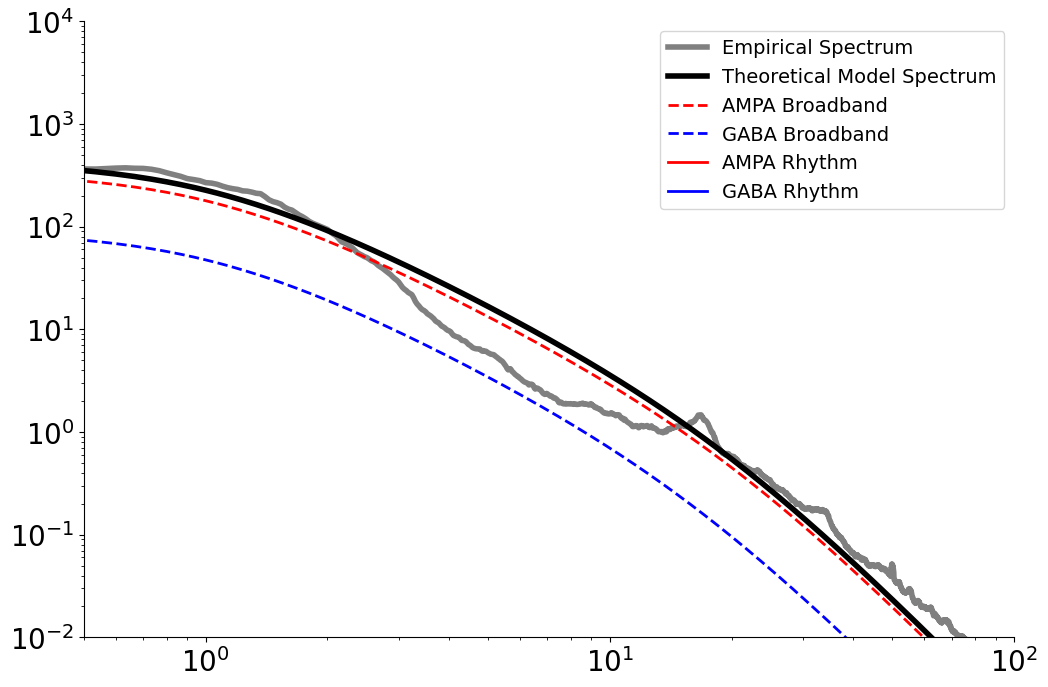

In [58]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

infusion_params = [2.27675109e+04, 6.79678298e+02, 1.03742954e+02, 2.43979565e+02,
 7.99997309e+00, 9.81179409e+00, 3.59794770e-01, 1.20320066e-01,
 6.54483556e+00]

lambda_0_AMPA, lambda_0_GABA, transform_param_1, \
transform_param_2, tau_decay_AMPA, tau_decay_GABA, \
tau_rise_AMPA, tau_rise_GABA, A_filter = infusion_params

spectrogram_linear = data['Spectrogram (Original)']
start_time = 35
end_time = start_time + 4
time_range_filter = (time >= start_time) & (time < end_time)
filtered_time_range = time[time_range_filter]
filtered_spectrogram_range = spectrogram_linear[:, time_range_filter]

# Calculate mean power spectrum for the filtered time range
mean_power_spectrum = filtered_spectrogram_range.mean(axis=1)


negative_frequencies = -frequencies[1:][::-1]  # Exclude zero frequency and reverse
negative_power_spectrum = mean_power_spectrum[1:][::-1]  # Exclude zero frequency power and reverse

# Concatenate negative and positive frequencies
extended_frequencies = np.concatenate((negative_frequencies, frequencies))
extended_power_spectrum = np.concatenate((negative_power_spectrum, mean_power_spectrum))

  
new_params = {
    'method': 'Homogeneous_Poisson',
    'lambda_0': [0],   # lambda_0 dummy value here (will be updated so this is not necessary in the multivariate refactoring)ed
    'fs': 1/0.001,   
    'T': 1,           
    'Nsims': 1,
    'frequency_vector': frequencies     
}

# Instantiate the PointProcessModel with current parameters
model_1 = PointProcessModel(params=new_params, seed=45)

# Calculate the theoretical spectrum (CIF) with the current parameters
S_ampa = model_1.cif_PSD
S_gaba = model_1.cif_PSD 

theoretical_frequencies = model_1.params['frequencies']

# Define the filters to be used
filters = {
    'AMPA': 'AMPA',
    'GABA': 'GABA',
    '1/f': '1/f'
}

# Define custom parameters for the filters
filter_params = {
    'AMPA': {'tau_rise': tau_rise_AMPA / 1000, 'tau_decay': tau_decay_AMPA / 1000},
    'GABA': {'tau_rise': tau_rise_GABA / 1000, 'tau_decay': tau_decay_GABA / 1000},
    '1/f': {'A': A_filter}
}

# Instantiate the FilteredPointProcess class with the specified filters, model, and custom parameters
fpp = FilteredPointProcess(filters=filters, model=model_1, filter_params=filter_params)

filter_spectra = fpp.get_filters()

# Ensure all spectra are correctly aligned
mirrored_positive_filters_ampa = filter_spectra['AMPA']['power_spectrum']
mirrored_positive_filters_gaba = filter_spectra['GABA']['power_spectrum']
mirrored_positive_filters_1_f = filter_spectra['1/f']['power_spectrum']

# Constructing the S_ampa_gaba tensor directly using CIF
S_ampa_gaba = np.zeros((2, 2, len(theoretical_frequencies)), dtype=complex)

# Fill the tensor with provided data using the correct spectral equations
S_ampa_gaba[0, 0, :] = (S_ampa + lambda_0_AMPA) * mirrored_positive_filters_ampa * mirrored_positive_filters_1_f
S_ampa_gaba[0, 1, :] = 0  # no cross-terms
S_ampa_gaba[1, 0, :] = 0  # no cross-terms
S_ampa_gaba[1, 1, :] = (S_gaba + lambda_0_GABA) * mirrored_positive_filters_gaba * mirrored_positive_filters_1_f

# Define the transformation vector
transformation_vector = np.array([transform_param_1, transform_param_2])
transformation_vector_squared = transformation_vector ** 2

# Apply the correct transformation in the frequency domain using einsum
S_transformed = np.einsum('ijk,j->ijk', S_ampa_gaba, transformation_vector_squared)

# Calculate the final spectrum: sum of the components transformed by the squared vector
theoretical_spectrum = np.sum(S_transformed, axis=(0, 1))

# Individual subcomponents after transformation
CIF_AMPA = (
    S_ampa
    * mirrored_positive_filters_ampa
    * mirrored_positive_filters_1_f
    * transformation_vector_squared[0]
)
CIF_GABA = (
    S_gaba
    * mirrored_positive_filters_gaba
    * mirrored_positive_filters_1_f
    * transformation_vector_squared[1]
)

GABA_broadband = (
    np.full(len(S_gaba), lambda_0_GABA)
    * mirrored_positive_filters_gaba
    * mirrored_positive_filters_1_f
    * transformation_vector_squared[1]
)
AMPA_broadband = (
    np.full(len(S_ampa), lambda_0_AMPA)
    * mirrored_positive_filters_ampa
    * mirrored_positive_filters_1_f
    * transformation_vector_squared[0]
)


# Plotting the results
fig, ax3 = plt.subplots(figsize=(12, 8))

extended_frequencies_spectrum_2 = extended_frequencies
extended_power_spectrum_spectrum_2 = extended_power_spectrum
theoretical_spectrum_spectrum_2 = theoretical_spectrum
AMPA_broadband_spectrum_2 = AMPA_broadband
GABA_broadband_spectrum_2 = GABA_broadband
CIF_AMPA_spectrum_2 = CIF_AMPA
CIF_GABA_spectrum_2 = CIF_GABA

# Plot the empirical and theoretical spectra
ax3.loglog(extended_frequencies_spectrum_2, extended_power_spectrum_spectrum_2, color='grey', label='Empirical Spectrum', linewidth=4)
ax3.loglog(extended_frequencies_spectrum_2, theoretical_spectrum_spectrum_2, color='black', label='Theoretical Model Spectrum', linewidth=4)

# Plot the AMPA and GABA subcomponents
ax3.loglog(extended_frequencies_spectrum_2, AMPA_broadband_spectrum_2, color='red', label='AMPA Broadband', linestyle='--', linewidth=2)
ax3.loglog(extended_frequencies_spectrum_2, GABA_broadband_spectrum_2, color='blue', label='GABA Broadband', linestyle='--', linewidth=2)
ax3.loglog(extended_frequencies_spectrum_2, CIF_AMPA_spectrum_2, color='red', label='AMPA Rhythm', linestyle='-', linewidth=2)
ax3.loglog(extended_frequencies_spectrum_2, CIF_GABA_spectrum_2, color='blue', label='GABA Rhythm', linestyle='-', linewidth=2)

# Customize the plot
ax3.set_xlim(0.5, 100)
ax3.set_ylim(1e-2, 1e4)
ax3.tick_params(axis='both', which='major', labelsize=20)

# Remove the top and right lines
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

# Add the legend
ax3.legend(fontsize=14, loc='upper right')

plt.show()


## Spectrogram

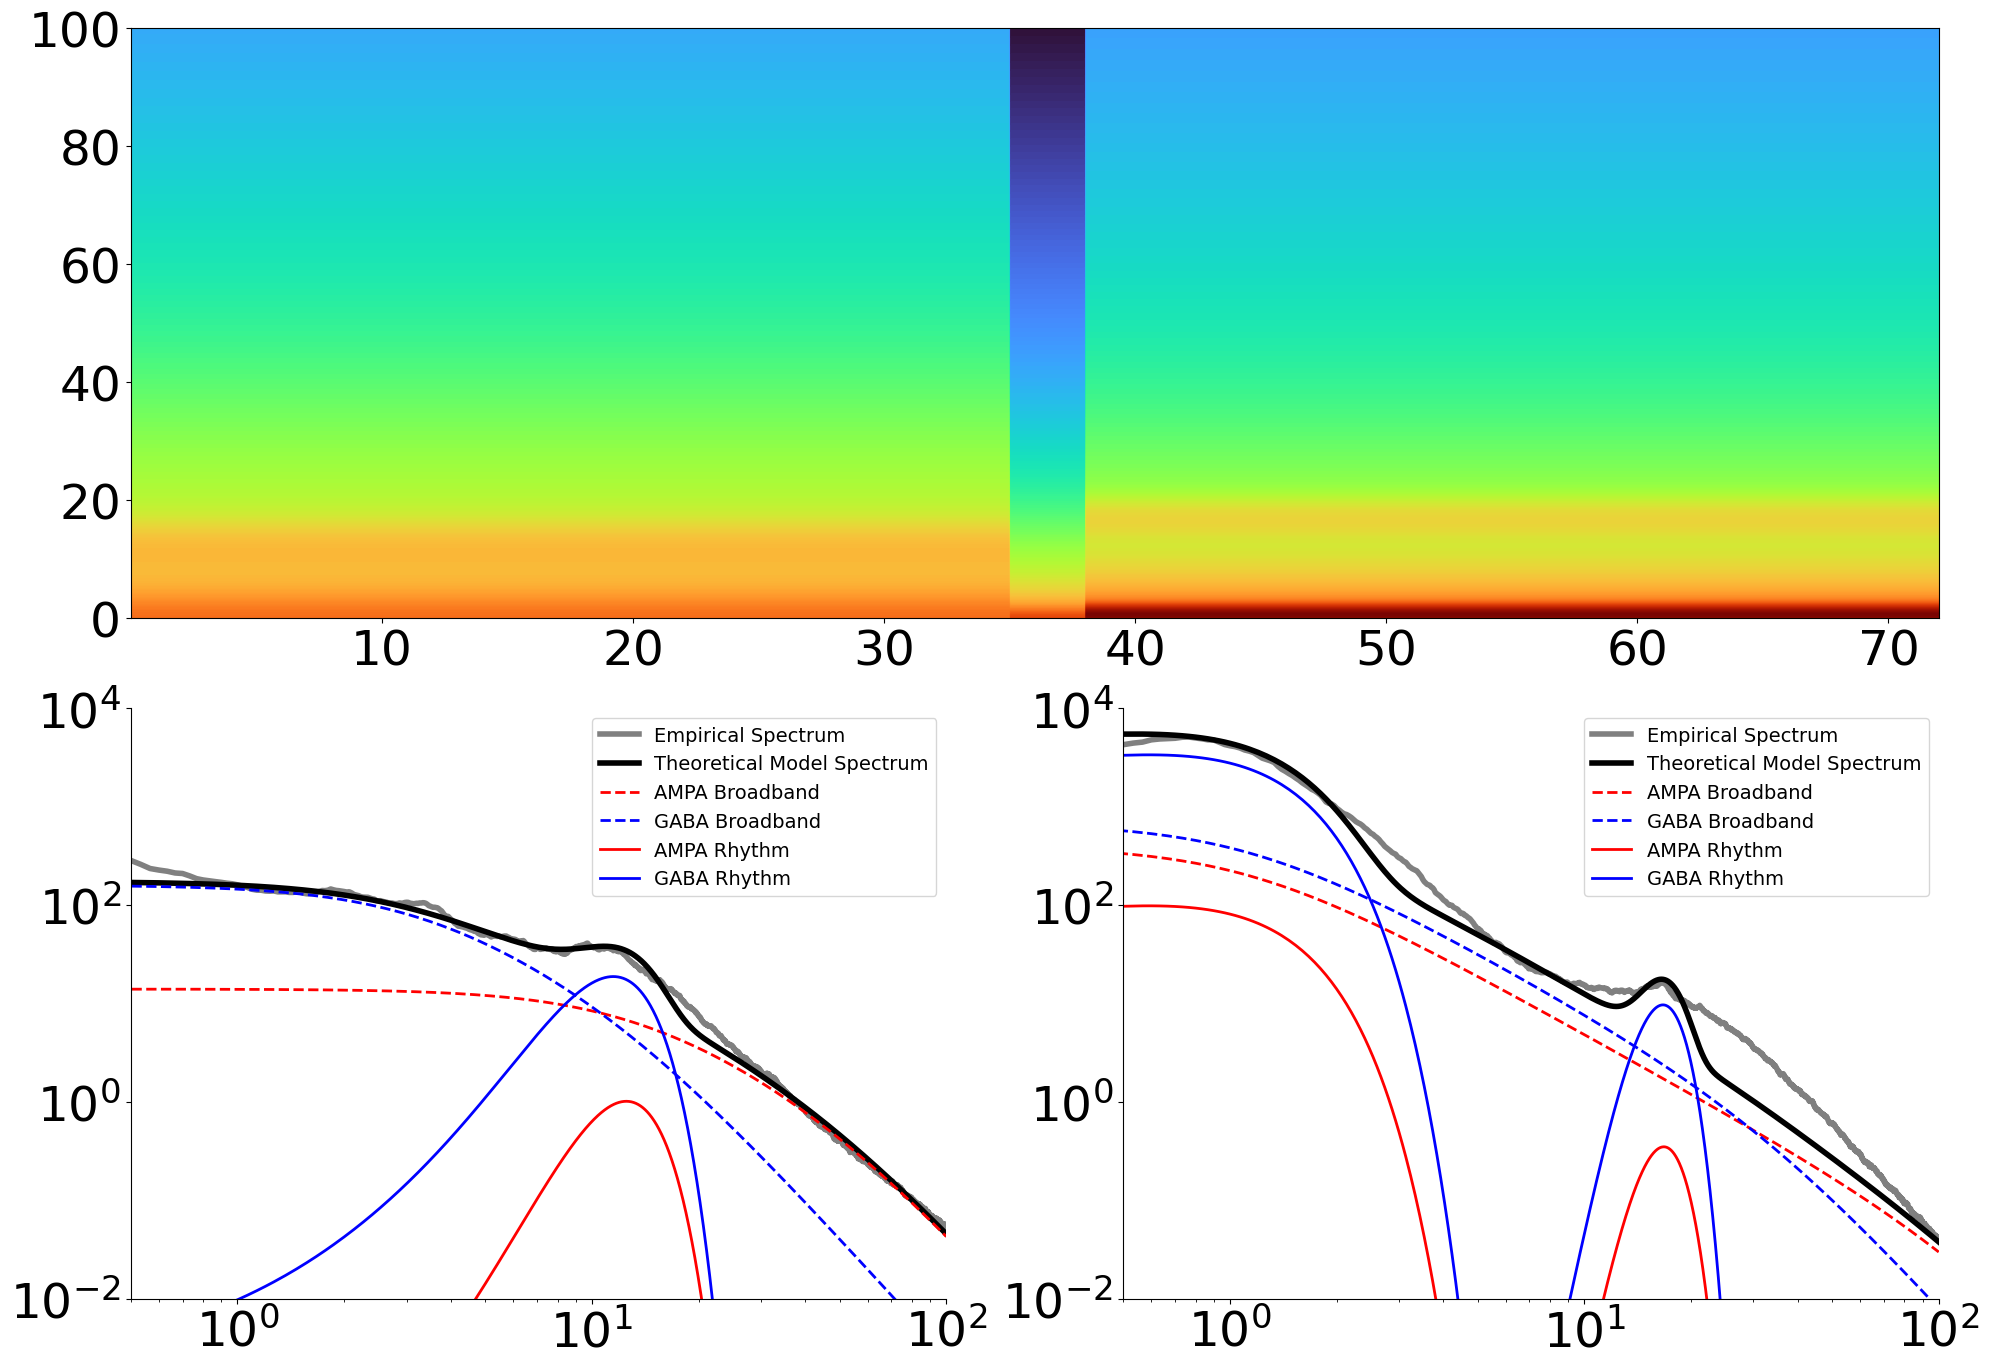

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Define time duration for each condition (in minutes)
duration_panel_1 = 35  # Duration for spectrum_3 (Awake)
duration_panel_3 = 3   # Duration for spectrum_2 (Intermediate)
duration_panel_2 = 34  # Duration for spectrum_1 (Anesthesia)

# Convert duration to seconds
duration_panel_1_sec = duration_panel_1 * 60
duration_panel_3_sec = duration_panel_3 * 60
duration_panel_2_sec = duration_panel_2 * 60

# Create time vectors
time_panel_1 = np.linspace(0, duration_panel_1, duration_panel_1_sec)
time_panel_3 = np.linspace(duration_panel_1, duration_panel_1 + duration_panel_3, duration_panel_3_sec)
time_panel_2 = np.linspace(duration_panel_1 + duration_panel_3, duration_panel_1 + duration_panel_3 + duration_panel_2, duration_panel_2_sec)
total_time = np.concatenate([time_panel_1, time_panel_3, time_panel_2])

# Filter the frequencies between 0 and 100 Hz
freq_filter = (extended_frequencies >= 0) & (extended_frequencies <= 100)

# Filtered frequency and power spectrum for each spectrum
extended_frequencies_filtered = extended_frequencies[freq_filter]

# Repeat the spectra
spectrogram_panel_3 = np.tile(np.log10(np.abs(theoretical_spectrum_spectrum_3[freq_filter])), (len(time_panel_1), 1)).T
spectrogram_panel_2 = np.tile(np.log10(np.abs(theoretical_spectrum_spectrum_2[freq_filter])), (len(time_panel_3), 1)).T
spectrogram_panel_1 = np.tile(np.log10(np.abs(theoretical_spectrum_spectrum_1[freq_filter])), (len(time_panel_2), 1)).T

# Combine the spectrograms
combined_spectrogram = np.concatenate([spectrogram_panel_3, spectrogram_panel_2, spectrogram_panel_1], axis=1)

# Create a figure with three subplots
fig = plt.figure(figsize=(20, 20))

# Spectrogram on top
ax1 = fig.add_subplot(3, 1, 1)
cax = ax1.imshow(combined_spectrogram, aspect='auto', extent=[total_time.min(), total_time.max(), extended_frequencies_filtered.min(), extended_frequencies_filtered.max()], origin='lower', cmap='turbo')
ax1.set_xticks([10, 20, 30, 40, 50, 60, 70])
ax1.tick_params(axis='both', which='major', labelsize=35)

# Add colorbar for the spectrogram
#cbar = plt.colorbar(cax, ax=ax1, orientation='horizontal', pad=0.2)
#cbar.set_label('Log Power Spectrum', fontsize=25)
#cbar.ax.tick_params(labelsize=20)

# Panel 1 (Awake) on the bottom left
ax2 = fig.add_subplot(3, 2, 3)
ax2.loglog(extended_frequencies_spectrum_3, extended_power_spectrum_spectrum_3, color='grey', label='Empirical Spectrum', linewidth=4)
ax2.loglog(extended_frequencies_spectrum_3, theoretical_spectrum_spectrum_3, color='black', label='Theoretical Model Spectrum', linewidth=4)
ax2.loglog(extended_frequencies_spectrum_3, AMPA_broadband_spectrum_3, color='red', label='AMPA Broadband', linestyle='--', linewidth=2)
ax2.loglog(extended_frequencies_spectrum_3, GABA_broadband_spectrum_3, color='blue', label='GABA Broadband', linestyle='--', linewidth=2)
ax2.loglog(extended_frequencies_spectrum_3, CIF_AMPA_spectrum_3, color='red', label='AMPA Rhythm', linestyle='-', linewidth=2)
ax2.loglog(extended_frequencies_spectrum_3, CIF_GABA_spectrum_3, color='blue', label='GABA Rhythm', linestyle='-', linewidth=2)

ax2.set_xlim(0.5, 100)
ax2.set_ylim(1e-2, 1e4)
ax2.tick_params(axis='both', which='major', labelsize=35)

# Remove the top and right lines
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Panel 2 (Anesthesia) on the bottom right
ax3 = fig.add_subplot(3, 2, 4)
ax3.loglog(extended_frequencies_spectrum_1, extended_power_spectrum_spectrum_1, color='grey', label='Empirical Spectrum', linewidth=4)
ax3.loglog(extended_frequencies_spectrum_1, theoretical_spectrum_spectrum_1, color='black', label='Theoretical Model Spectrum', linewidth=4)
ax3.loglog(extended_frequencies_spectrum_1, AMPA_broadband_spectrum_1, color='red', label='AMPA Broadband', linestyle='--', linewidth=2)
ax3.loglog(extended_frequencies_spectrum_1, GABA_broadband_spectrum_1, color='blue', label='GABA Broadband', linestyle='--', linewidth=2)
ax3.loglog(extended_frequencies_spectrum_1, CIF_AMPA_spectrum_1, color='red', label='AMPA Rhythm', linestyle='-', linewidth=2)
ax3.loglog(extended_frequencies_spectrum_1, CIF_GABA_spectrum_1, color='blue', label='GABA Rhythm', linestyle='-', linewidth=2)

ax3.set_xlim(0.5, 100)
ax3.set_ylim(1e-2, 1e4)
ax3.tick_params(axis='both', which='major', labelsize=35)

# Remove the top and right lines
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

# Remove the boxes around the legends and add the legend outside
ax2.legend(fontsize=14, loc='upper right')
ax3.legend(fontsize=14, loc='upper right')

plt.tight_layout()

# Save the figure

plt.show()


In [64]:
#Awake_rhythm, 
#Optimized_Parameters_Anesthesia_5, 
infusion_params

#Awake
#peak_height_1, center_frequency_1, peak_width_1, \
#peak_height_2, center_frequency_2, peak_width_2, \
#lambda_0_AMPA, lambda_0_GABA, transform_param_1, \
#transform_param_2, tau_decay_AMPA, tau_decay_GABA, \
#tau_rise_AMPA, tau_rise_GABA, A_filter = optimized_params



[22767.5109,
 679.678298,
 103.742954,
 243.979565,
 7.99997309,
 9.81179409,
 0.35979477,
 0.120320066,
 6.54483556]